# Example of the usage of the Weak label classifier

In [1]:
## Example_mlp_test_resnet.ipynb

#This notebook is copied from `Example_mlp_test.ipynb`.

#Changes: no hidden layer


We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [2]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import UpperBoundWeakProperLoss
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [3]:
dataset_name = 'mnist'
Data = Data_handling(
    # dataset='mnist',
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=True,
    splitting_seed=42
)

In [4]:
""" Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df """


" Data.train_dataset.data # This is Train_X\nData.train_dataset.targets # This is Train_y\nprint(Data.test_dataset.targets)\ndf = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])\ndf['target'] = [i for i in Data.train_dataset.targets.numpy()]\ndf "

In [5]:
Data.num_classes

10

In [6]:
""" df_2_plot = df.iloc[0:1000]
features = ['feature_102', 'feature_103']
visualize_dataset(
    df_2_plot,
    features=features,
    classes=Data.num_classes,
    title=dataset_name,
) """


" df_2_plot = df.iloc[0:1000]\nfeatures = ['feature_102', 'feature_103']\nvisualize_dataset(\n    df_2_plot,\n    features=features,\n    classes=Data.num_classes,\n    title=dataset_name,\n) "

In [7]:
""" df_2_plot[[features[0], features[1]]] """


' df_2_plot[[features[0], features[1]]] '

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [8]:
corr_p = 0.0
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=corr_p)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
#print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Generated z (noisy labels):
tensor([4, 9, 5,  ..., 4, 3, 1], dtype=torch.int32)
Inputs batch shape: torch.Size([64, 784])
Weak (partial) labels shape: torch.Size([64])
True one-hot labels shape: torch.Size([64, 10])


In [9]:
#weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
#df['target'] = [i for i in weakener.w.numpy()]
#df

# 1) 展平成 (N, 3072)
X = Data.train_dataset.data                # (N, 3, 32, 32)  (torch tensor)
X2 = X.view(X.shape[0], -1).cpu().numpy()  # (N, 3072)

weak_df = pd.DataFrame(X2, columns=[f'feature_{i}' for i in range(X2.shape[1])])

# 2) 加 true label（如果 targets 是 one-hot，就转成 class index）
y = Data.train_dataset.targets
if hasattr(y, "ndim") and y.ndim == 2:
    y = y.argmax(dim=1)
weak_df["target"] = y.cpu().numpy()

# 3) 加 weak label（weakener.w 可能是一维或二维：做个兼容）
w = weakener.w
w_np = w.detach().cpu().numpy()

if w_np.ndim == 1:
    weak_df["weak"] = w_np
else:
    # 如果是 one-hot / multi-hot (N,C)，你可以：
    # A) 每一类一列（适合做统计）
    for c in range(w_np.shape[1]):
        weak_df[f"weak_{c}"] = w_np[:, c]
    # 或 B) 压缩成“候选集合”（适合阅读）
    # weak_df["weak_set"] = [np.flatnonzero(row).tolist() for row in w_np]

weak_df


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,weak_0,weak_1,weak_2,weak_3,weak_4,weak_5,weak_6,weak_7,weak_8,weak_9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
# visualize_dataset(
#     df,
#     features=['feature_0', 'feature_1'],
#     classes=3,
#     title='Iris Samples with Pie Markers for Multi-Label Entries'
# )



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: 0.0045, Train Acc: 0.9193, Test Acc: 0.9209, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.89 seconds
Epoch 20/60: Train Loss: 0.0042, Train Acc: 0.9253, Test Acc: 0.9257, Train Detached Loss: 0.0042, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 13.00 seconds
Epoch 30/60: Train Loss: 0.0040, Train Acc: 0.9280, Test Acc: 0.9265, Train Detached Loss: 0.0040, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 13.22 seconds
Epoch 40/60: Train Loss: 0.0040, Train Acc: 0.9303, Test Acc: 0.9277, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 13.70 seconds
Epoch 50/60: Train Loss: 0.0039, Train Acc: 0.9312, Test Acc: 0.9265, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 14.51 seconds
Epoch 60/60: Train Loss: 0.0039, Train Acc: 0.9324, Tes

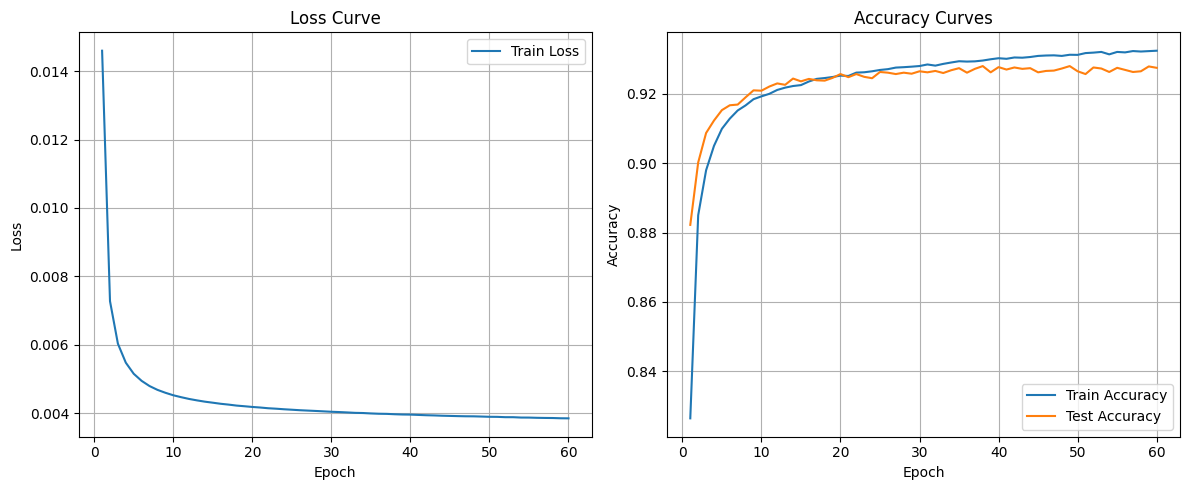

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


""" import torch.nn as nn
import torchvision.models as models

def resnet18_cifar(num_classes: int):
    m = models.resnet18(weights=None)
    # CIFAR10: 32x32，改第一层卷积 + 去掉 maxpool
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18_cifar(Data.num_classes).to(device)
 """

""" optimizer = optim.Adam(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
) """




# 0) 先从 loader 拿一个 batch 推断 input_dim
""" xb, wb, yb = next(iter(train_loader))
input_dim = int(np.prod(xb.shape[1:]))   # CIFAR10 通常是 3*32*32=3072

print("xb shape:", xb.shape, "=> input_dim:", input_dim)

# 1) 模型：先 Flatten 再 MLP（这样即使 xb 是 4D 也能喂给 MLP）
model = nn.Sequential(
    nn.Flatten(start_dim=1),
    MLP(
        input_size=input_dim,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu'
    )
)
 """

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],    #MLP两层隐藏层
    output_size=Data.num_classes,
    dropout_p=0.2,       #加一点dropout
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)

#optimizer = optim.SGD(
#    model.parameters(),
#    lr=0.01,
#    momentum=0.0  # 0.9
#)

# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [12]:
import os
print(os.getenv("PYTHONBREAKPOINT"))

None


Using device: cuda
Initializing MLP model...
784
[]
10


Epoch 10/60: Train Loss: 0.0045, Train Acc: 0.9193, Test Acc: 0.9209, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.77 seconds
Epoch 20/60: Train Loss: 0.0042, Train Acc: 0.9253, Test Acc: 0.9257, Train Detached Loss: 0.0042, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 12.13 seconds
Epoch 30/60: Train Loss: 0.0040, Train Acc: 0.9280, Test Acc: 0.9265, Train Detached Loss: 0.0040, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 13.76 seconds
Epoch 40/60: Train Loss: 0.0040, Train Acc: 0.9303, Test Acc: 0.9277, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 16.31 seconds
Epoch 50/60: Train Loss: 0.0039, Train Acc: 0.9312, Test Acc: 0.9265, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 15.17 seconds
Epoch 60/60: Train Loss: 0.0039, Train Acc: 0.9324, Test Acc: 0.9275, Train Detached Loss: 0.0038, Test Detach

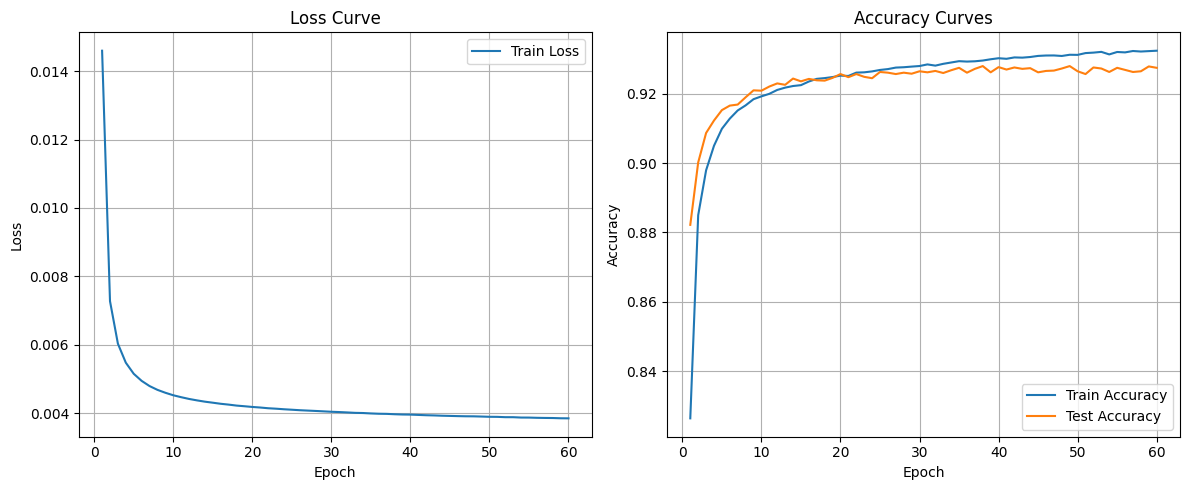

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)


# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = ForwardProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [14]:
import torch
from torch import nn

# 1. 固定随机种子
torch.manual_seed(0)

B, C = 5, 4

logits = torch.randn(B, C, requires_grad=True)
z = torch.randint(0, C, (B,))

M = torch.rand(C, C)
M = M / M.sum(dim=1, keepdim=True)
F = M.clone()

# 这里贴上你的 MarginalChainProperLoss 和 ForwardProperLoss 定义
# loss_code="cross_entropy"

mc_loss_fn = MarginalChainProperLoss(M, loss_code="cross_entropy", reduction="mean")
fw_loss_fn = ForwardProperLoss(F, loss_code="cross_entropy", reduction="mean")

# Marginal chain
logits_mc = logits.clone().detach().requires_grad_(True)
loss_mc = mc_loss_fn(logits_mc, z)
loss_mc.backward()
grad_mc = logits_mc.grad.clone().detach()

# Forward
logits_fw = logits.clone().detach().requires_grad_(True)
loss_fw = fw_loss_fn(logits_fw, z)
loss_fw.backward()
grad_fw = logits_fw.grad.clone().detach()

print("loss_mc:", loss_mc.item())
print("loss_fw:", loss_fw.item())
print("loss diff:", abs(loss_mc.item() - loss_fw.item()))

print("grad same?", torch.allclose(grad_mc, grad_fw, atol=1e-6))
print("grad max diff:", (grad_mc - grad_fw).abs().max().item())


loss_mc: 1.3477718830108643
loss_fw: 1.3477718830108643
loss diff: 0.0
grad same? True
grad max diff: 1.1175870895385742e-08


In [15]:
# 取一个 batch
xb, zb, yb = next(iter(train_loader))   # 确保 zb 就是 z（weak index）
xb = xb.to(device)
zb = zb.to(device)

logits = model(xb)

fwd_loss_fn = ForwardProperLoss(weakener.M, "cross_entropy").to(device)
ub_loss_fn  = UpperBoundWeakProperLoss(weakener.M, "cross_entropy").to(device)

loss_fwd = fwd_loss_fn(logits, zb)
loss_ub  = ub_loss_fn(logits, zb)

print("loss_fwd:", loss_fwd.item())
print("loss_ub :", loss_ub.item())

g1 = torch.autograd.grad(loss_fwd, logits, retain_graph=True)[0]
g2 = torch.autograd.grad(loss_ub,  logits)[0]
print("grad norm fwd:", g1.norm().item())
print("grad norm ub :",  g2.norm().item())


loss_fwd: 0.15329524874687195
loss_ub : 0.15329524874687195
grad norm fwd: 0.034025318920612335
grad norm ub : 0.034025318920612335


Using device: cuda
Initializing MLP model...
784
[]
10


Epoch 10/60: Train Loss: 0.0045, Train Acc: 0.9193, Test Acc: 0.9209, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 14.46 seconds
Epoch 20/60: Train Loss: 0.0042, Train Acc: 0.9253, Test Acc: 0.9257, Train Detached Loss: 0.0042, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 16.08 seconds
Epoch 30/60: Train Loss: 0.0040, Train Acc: 0.9280, Test Acc: 0.9265, Train Detached Loss: 0.0040, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 15.69 seconds
Epoch 40/60: Train Loss: 0.0040, Train Acc: 0.9303, Test Acc: 0.9277, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 15.54 seconds
Epoch 50/60: Train Loss: 0.0039, Train Acc: 0.9312, Test Acc: 0.9265, Train Detached Loss: 0.0039, Test Detached Loss: 0.0042, Learning Rate: 0.000001, Epoch Time: 15.90 seconds
Epoch 60/60: Train Loss: 0.0039, Train Acc: 0.9324, Test Acc: 0.9275, Train Detached Loss: 0.0038, Test Detach

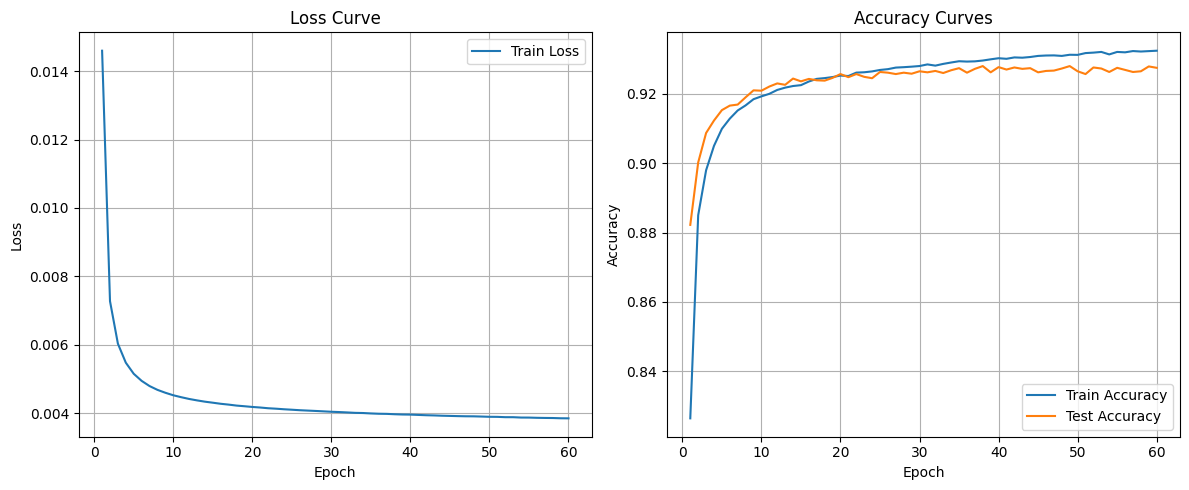

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)


# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: -0.0052, Train Acc: 0.6797, Test Acc: 0.6809, Train Detached Loss: 0.0721, Test Detached Loss: 0.0739, Learning Rate: 0.000001, Epoch Time: 16.58 seconds
Epoch 20/60: Train Loss: -0.0053, Train Acc: 0.6838, Test Acc: 0.6829, Train Detached Loss: 0.1108, Test Detached Loss: 0.1137, Learning Rate: 0.000001, Epoch Time: 17.13 seconds
Epoch 30/60: Train Loss: -0.0053, Train Acc: 0.6858, Test Acc: 0.6830, Train Detached Loss: 0.1532, Test Detached Loss: 0.1568, Learning Rate: 0.000001, Epoch Time: 16.06 seconds
Epoch 40/60: Train Loss: -0.0053, Train Acc: 0.6874, Test Acc: 0.6834, Train Detached Loss: 0.1868, Test Detached Loss: 0.1916, Learning Rate: 0.000001, Epoch Time: 16.06 seconds
Epoch 50/60: Train Loss: -0.0053, Train Acc: 0.6882, Test Acc: 0.6832, Train Detached Loss: 0.2018, Test Detached Loss: 0.2072, Learning Rate: 0.000001, Epoch Time: 16.76 seconds
Epoch 60/60: Train Loss: -0.0053, Train Acc: 0.689

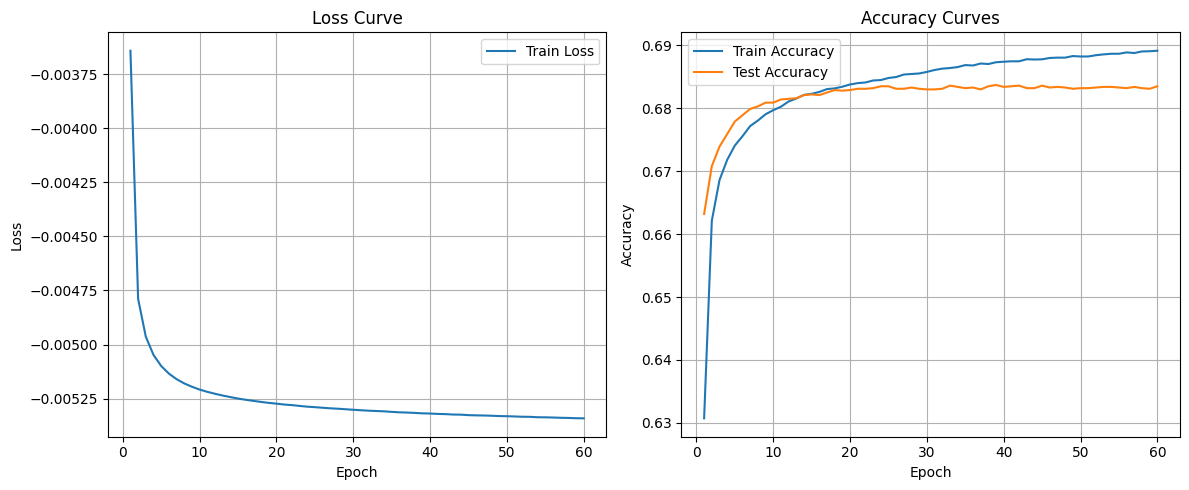

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: -0.0052, Train Acc: 0.6797, Test Acc: 0.6809, Train Detached Loss: 0.0721, Test Detached Loss: 0.0739, Learning Rate: 0.000001, Epoch Time: 14.34 seconds
Epoch 20/60: Train Loss: -0.0053, Train Acc: 0.6838, Test Acc: 0.6829, Train Detached Loss: 0.1108, Test Detached Loss: 0.1137, Learning Rate: 0.000001, Epoch Time: 14.07 seconds
Epoch 30/60: Train Loss: -0.0053, Train Acc: 0.6858, Test Acc: 0.6830, Train Detached Loss: 0.1532, Test Detached Loss: 0.1568, Learning Rate: 0.000001, Epoch Time: 13.47 seconds
Epoch 40/60: Train Loss: -0.0053, Train Acc: 0.6874, Test Acc: 0.6834, Train Detached Loss: 0.1868, Test Detached Loss: 0.1916, Learning Rate: 0.000001, Epoch Time: 13.24 seconds
Epoch 50/60: Train Loss: -0.0053, Train Acc: 0.6882, Test Acc: 0.6832, Train Detached Loss: 0.2018, Test Detached Loss: 0.2072, Learning Rate: 0.000001, Epoch Time: 13.20 seconds
Epoch 60/60: Train Loss: -0.0053, Train Acc: 0.689

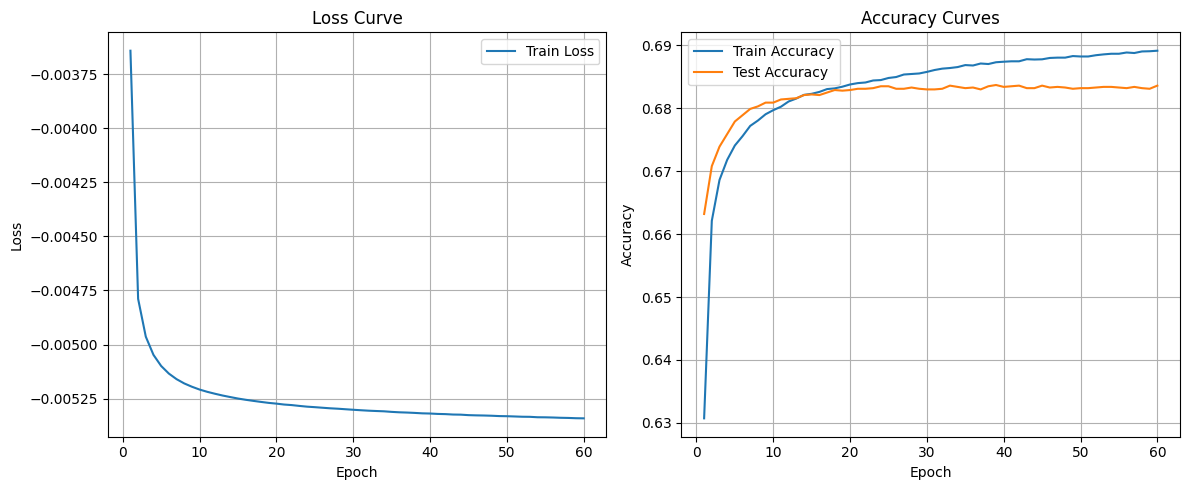

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = ForwardProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: -0.0052, Train Acc: 0.6797, Test Acc: 0.6809, Train Detached Loss: 0.0721, Test Detached Loss: 0.0739, Learning Rate: 0.000001, Epoch Time: 17.21 seconds
Epoch 20/60: Train Loss: -0.0053, Train Acc: 0.6838, Test Acc: 0.6829, Train Detached Loss: 0.1108, Test Detached Loss: 0.1137, Learning Rate: 0.000001, Epoch Time: 17.34 seconds
Epoch 30/60: Train Loss: -0.0053, Train Acc: 0.6858, Test Acc: 0.6830, Train Detached Loss: 0.1532, Test Detached Loss: 0.1568, Learning Rate: 0.000001, Epoch Time: 16.64 seconds
Epoch 40/60: Train Loss: -0.0053, Train Acc: 0.6874, Test Acc: 0.6834, Train Detached Loss: 0.1868, Test Detached Loss: 0.1916, Learning Rate: 0.000001, Epoch Time: 15.94 seconds
Epoch 50/60: Train Loss: -0.0053, Train Acc: 0.6882, Test Acc: 0.6832, Train Detached Loss: 0.2018, Test Detached Loss: 0.2072, Learning Rate: 0.000001, Epoch Time: 17.02 seconds
Epoch 60/60: Train Loss: -0.0053, Train Acc: 0.689

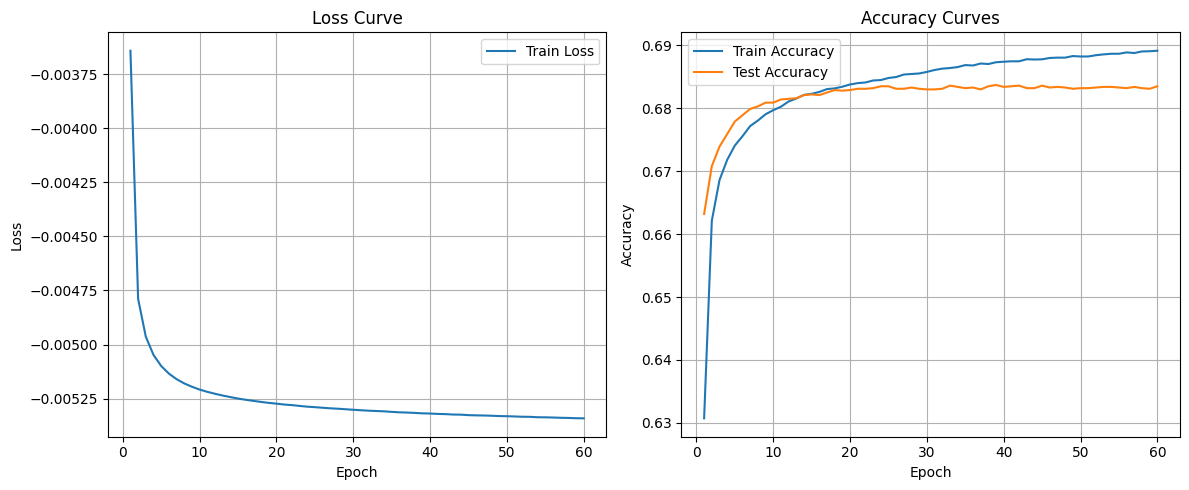

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10


Epoch 10/60: Train Loss: 0.0384, Train Acc: 0.8627, Test Acc: 0.8716, Train Detached Loss: 0.0062, Test Detached Loss: 0.0061, Learning Rate: 0.000001, Epoch Time: 12.99 seconds
Epoch 20/60: Train Loss: 0.0343, Train Acc: 0.8738, Test Acc: 0.8834, Train Detached Loss: 0.0057, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 14.14 seconds
Epoch 30/60: Train Loss: 0.0322, Train Acc: 0.8792, Test Acc: 0.8843, Train Detached Loss: 0.0055, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 14.68 seconds
Epoch 40/60: Train Loss: 0.0309, Train Acc: 0.8818, Test Acc: 0.8865, Train Detached Loss: 0.0054, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 15.15 seconds
Epoch 50/60: Train Loss: 0.0299, Train Acc: 0.8840, Test Acc: 0.8886, Train Detached Loss: 0.0053, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 14.22 seconds
Epoch 60/60: Train Loss: 0.0291, Train Acc: 0.8844, Test Acc: 0.8895, Train Detached Loss: 0.0053, Test Detach

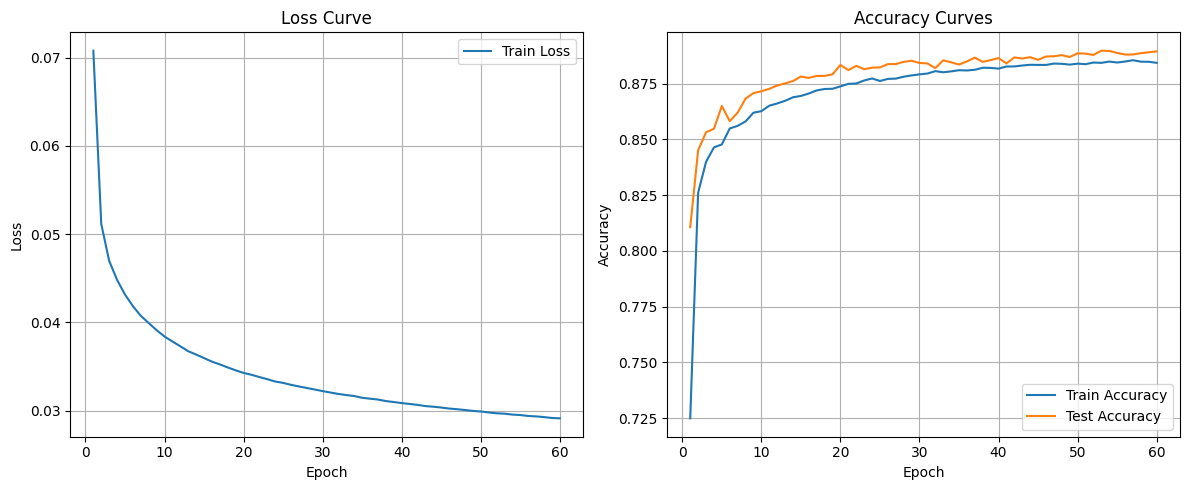

In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10


Epoch 10/60: Train Loss: 0.0130, Train Acc: 0.8964, Test Acc: 0.9004, Train Detached Loss: 0.0051, Test Detached Loss: 0.0050, Learning Rate: 0.000001, Epoch Time: 15.79 seconds
Epoch 20/60: Train Loss: 0.0119, Train Acc: 0.9009, Test Acc: 0.9044, Train Detached Loss: 0.0048, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 16.33 seconds
Epoch 30/60: Train Loss: 0.0113, Train Acc: 0.9031, Test Acc: 0.9069, Train Detached Loss: 0.0046, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 17.04 seconds
Epoch 40/60: Train Loss: 0.0109, Train Acc: 0.9050, Test Acc: 0.9069, Train Detached Loss: 0.0045, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 17.08 seconds
Epoch 50/60: Train Loss: 0.0107, Train Acc: 0.9057, Test Acc: 0.9075, Train Detached Loss: 0.0045, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 4.01 seconds
Epoch 60/60: Train Loss: 0.0105, Train Acc: 0.9059, Test Acc: 0.9083, Train Detached Loss: 0.0044, Test Detache

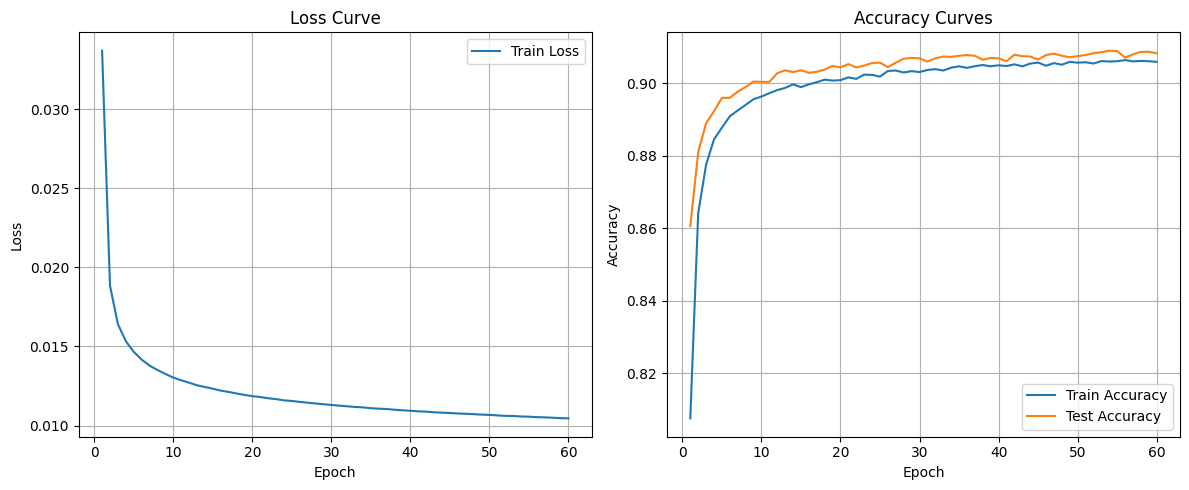

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0.2,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = ForwardProperLoss(weakener.M, loss_code="tsallis_0.5")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: 0.0382, Train Acc: 0.8627, Test Acc: 0.8713, Train Detached Loss: 0.0062, Test Detached Loss: 0.0061, Learning Rate: 0.000001, Epoch Time: 3.51 seconds
Epoch 20/60: Train Loss: 0.0340, Train Acc: 0.8735, Test Acc: 0.8833, Train Detached Loss: 0.0057, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 3.98 seconds
Epoch 30/60: Train Loss: 0.0318, Train Acc: 0.8791, Test Acc: 0.8838, Train Detached Loss: 0.0055, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 4.09 seconds
Epoch 40/60: Train Loss: 0.0303, Train Acc: 0.8816, Test Acc: 0.8864, Train Detached Loss: 0.0054, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 3.88 seconds
Epoch 50/60: Train Loss: 0.0293, Train Acc: 0.8839, Test Acc: 0.8881, Train Detached Loss: 0.0053, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 3.84 seconds
Epoch 60/60: Train Loss: 0.0285, Train Acc: 0.8843, Test Acc

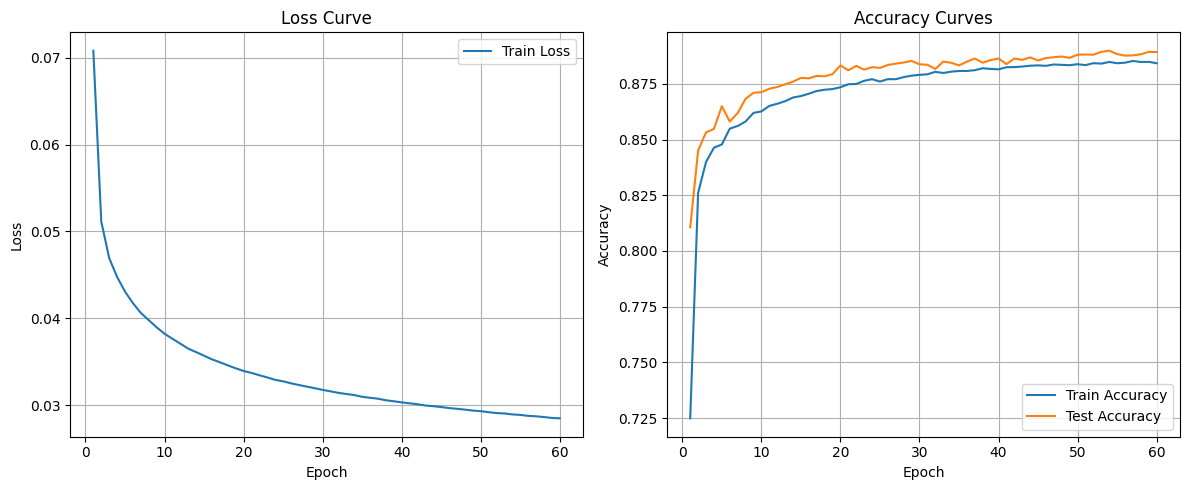

In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: 0.0019, Train Acc: 0.9244, Test Acc: 0.9275, Train Detached Loss: 0.0048, Test Detached Loss: 0.0047, Learning Rate: 0.000001, Epoch Time: 12.22 seconds
Epoch 20/60: Train Loss: 0.0017, Train Acc: 0.9323, Test Acc: 0.9314, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.38 seconds
Epoch 30/60: Train Loss: 0.0016, Train Acc: 0.9356, Test Acc: 0.9316, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 14.90 seconds
Epoch 40/60: Train Loss: 0.0016, Train Acc: 0.9382, Test Acc: 0.9329, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 14.86 seconds
Epoch 50/60: Train Loss: 0.0015, Train Acc: 0.9400, Test Acc: 0.9322, Train Detached Loss: 0.0044, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 14.02 seconds
Epoch 60/60: Train Loss: 0.0015, Train Acc: 0.9416, Tes

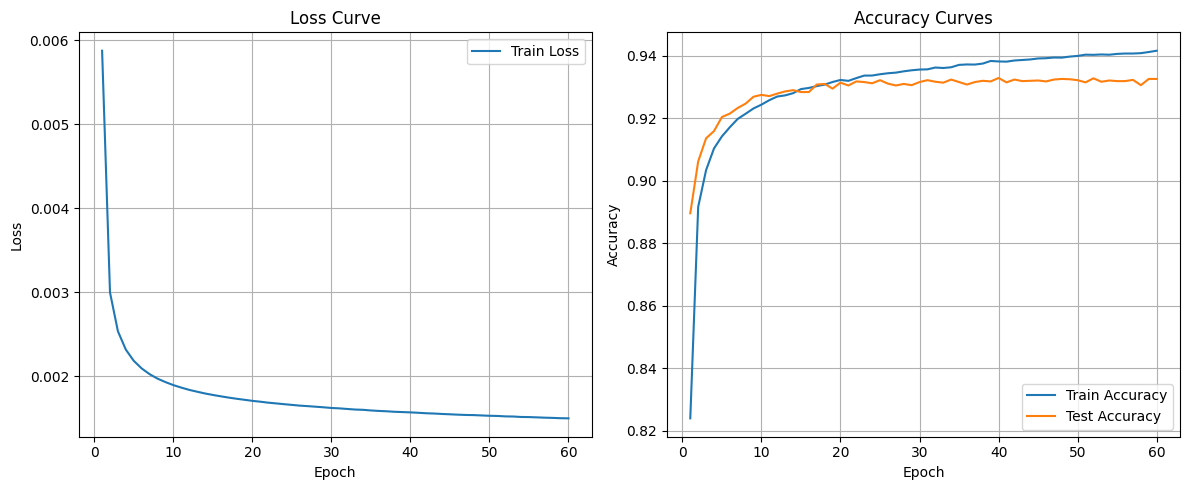

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="brier")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: 0.0019, Train Acc: 0.9244, Test Acc: 0.9275, Train Detached Loss: 0.0048, Test Detached Loss: 0.0047, Learning Rate: 0.000001, Epoch Time: 13.25 seconds
Epoch 20/60: Train Loss: 0.0017, Train Acc: 0.9323, Test Acc: 0.9314, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.73 seconds
Epoch 30/60: Train Loss: 0.0016, Train Acc: 0.9356, Test Acc: 0.9316, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.43 seconds
Epoch 40/60: Train Loss: 0.0016, Train Acc: 0.9382, Test Acc: 0.9329, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.79 seconds
Epoch 50/60: Train Loss: 0.0015, Train Acc: 0.9400, Test Acc: 0.9322, Train Detached Loss: 0.0044, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 13.56 seconds
Epoch 60/60: Train Loss: 0.0015, Train Acc: 0.9416, Tes

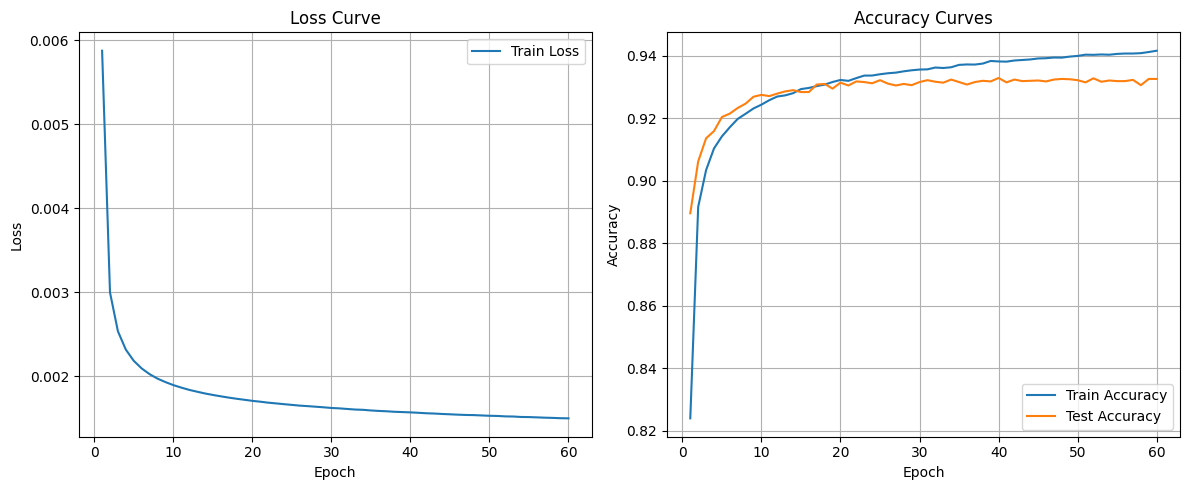

In [27]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = ForwardProperLoss(weakener.M, loss_code="brier")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Initializing MLP model...
784
[]
10
Epoch 10/60: Train Loss: 0.0019, Train Acc: 0.9244, Test Acc: 0.9275, Train Detached Loss: 0.0048, Test Detached Loss: 0.0047, Learning Rate: 0.000001, Epoch Time: 14.29 seconds
Epoch 20/60: Train Loss: 0.0017, Train Acc: 0.9323, Test Acc: 0.9314, Train Detached Loss: 0.0045, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 14.11 seconds
Epoch 30/60: Train Loss: 0.0016, Train Acc: 0.9356, Test Acc: 0.9316, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.50 seconds
Epoch 40/60: Train Loss: 0.0016, Train Acc: 0.9382, Test Acc: 0.9329, Train Detached Loss: 0.0044, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 13.03 seconds
Epoch 50/60: Train Loss: 0.0015, Train Acc: 0.9400, Test Acc: 0.9322, Train Detached Loss: 0.0044, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 13.19 seconds
Epoch 60/60: Train Loss: 0.0015, Train Acc: 0.9416, Tes

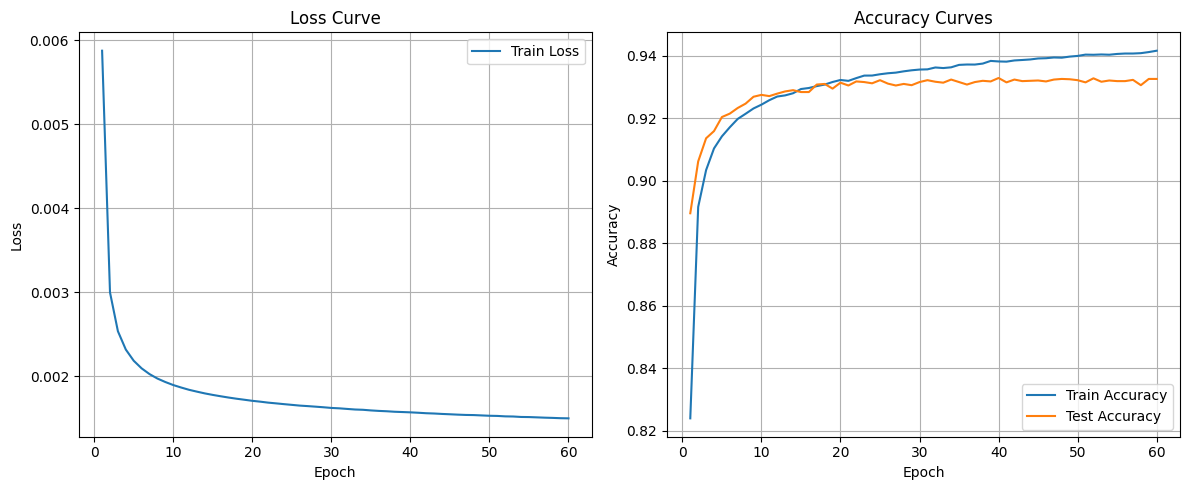

In [28]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="brier")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'clean_results' is not defined

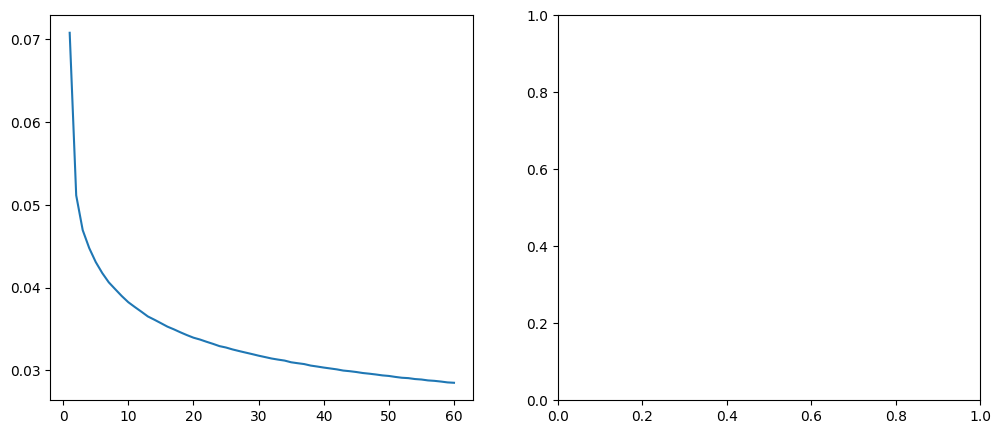

In [23]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()